# Analysis

This notebook contains the analysis of the data tracked on
[Weights & Biases](https://wandb.ai/).


## Setup

---

We will first setup everything so that we can easily analyse the experiment
results. This includes importing the necessary libraries, setting paths, loading
the experiment results from W&B.


In [1]:
# ruff: noqa
%load_ext autoreload
%autoreload 2

# Bult-in modules
import os
import sys

sys.path.insert(0, "..")

# Ignore warnings
import warnings

warnings.filterwarnings("ignore")

# External modules
# - Data Representation
import pandas as pd
import numpy as np

# - Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns
import plotnine as pn

# - Machine Learning
import torch

# - Experiment Configuration and Logging
import wandb

# Custom modules
from utils import eval_utils as utils

In [2]:
# Setup of global variables
ROOT_DIR = os.path.dirname(os.path.abspath("."))
ARTIFACT_DIR = os.path.join(ROOT_DIR, "artifacts")
FIGURE_DIR = os.path.join(ROOT_DIR, "report", "figures")
TABLE_DIR = os.path.join(ROOT_DIR, "report", "tables")

os.makedirs(FIGURE_DIR, exist_ok=True)
os.makedirs(TABLE_DIR, exist_ok=True)

METHODS = ["baseline", "baseline_pp", "matchingnet", "protonet", "maml"]
METHODS_WITH_SOT = []
for method in METHODS:
    METHODS_WITH_SOT.append(method)
    METHODS_WITH_SOT.append(method + "_sot")

STYLED_METHODS = ["Baseline", "Baseline++", "MatchingNet", "ProtoNet", "MAML"]
STYLED_METHODS_WITH_SOT = []
for method in STYLED_METHODS:
    STYLED_METHODS_WITH_SOT.append(method)
    STYLED_METHODS_WITH_SOT.append(method + " (SOT)")

styled_methods_dict = dict(zip(METHODS, STYLED_METHODS))


def get_name(name, sot=False):
    return styled_methods_dict[name] + (" (SOT)" if sot else "")

In [3]:
# Settings
sns.set_style("dark")
colorstyle = "YlGn_r"
sns.set_palette(colorstyle)

In [4]:
# Initialize wandb
WANDB_PROJECT = "few-shot-benchmark"
WANDB_ENTITY = "metameta-learners"

# Initialize W&B API
api = wandb.Api()

# Get all runs
runs = api.runs(f"{WANDB_ENTITY}/{WANDB_PROJECT}")

## Experiment 1: Benchmark

---

All models on all datasets with and without SOT for fixed few-shot learning
setting (5-way 5-shot).


### Loading Experiment Data


In [5]:
# Get all runs for experiment `benchmark`
GROUP = "new-tuned-benchmark"

group_runs = [run for run in runs if run.group ==
              GROUP and run.state == "finished"]
print(f"✅ Found {len(group_runs)} runs")

✅ Found 191 runs


Next, we'll load all runs from the given experiment group into a single
dataframe.


In [6]:
df_runs = utils.load_to_df(group_runs)
print(f"✅ Loaded {len(df_runs)} runs.")

df_runs.head()

✅ Loaded 191 runs.


info                 config  \
                                            name     runtime    dataset   
id                                                                        
3einpsxu         maml-swissprot-sot-5-way-5-shot  153.345022  swissprot   
4e6fdqop     baseline-swissprot-sot-5-way-5-shot  241.662610  swissprot   
ygmk9wc9         maml-swissprot-sot-5-way-5-shot  150.839164  swissprot   
qde026ke     baseline-swissprot-sot-5-way-5-shot  240.215852  swissprot   
6vfozfw4  baseline_pp-swissprot-sot-5-way-5-shot  351.343491  swissprot   

                                                 eval                         \
               method use_sot n_way n_shot    val/acc   test/acc test/acc_ci   
id                                                                             
3einpsxu         maml    True     5      5  20.000000  20.000000    0.000000   
4e6fdqop     baseline    True     5      5  62.433333  45.153333    0.809830   
ygmk9wc9         maml    True     5      5  20.000000  20.000000    0.000000   
qde026ke     baseline    True     5      5  66.020000  52.880000    0.724106   
6vfozfw4  baseline_pp    True     5      5  34.413333  34.013333    0.434944   

          ...                                                             \
          ...  train/acc train/acc_ci val/acc_ci test/acc_std train/loss   
id        ...                                                              
3einpsxu  ...  20.000000     0.000000   0.000000     0.000000        NaN   
4e6fdqop  ...  59.580000     1.054310   1.055651    10.120762   4.150271   
ygmk9wc9  ...  20.000000     0.000000   0.000000     0.000000        NaN   
qde026ke  ...  62.286667     1.105421   1.001795     9.049435   4.138412   
6vfozfw4  ...  35.306667     0.562925   0.597018     5.435668   4.235827   

                     hparams                                   
         val/acc_std      lr feat_dim sot_reg sot_dist_metric  
id                                                             
3einpsxu    0.000000   0.001       64    0.10       euclidean  
4e6fdqop   13.192885   0.010       64    0.01          cosine  
ygmk9wc9    0.000000   0.001       64    1.00       euclidean  
qde026ke   12.519835   0.010       64    0.10          cosine  
6vfozfw4    7.461177   0.100      512    1.00          cosine  

[5 rows x 22 columns]

### Grouping

Each experiment is uniquely identified by the following parameters:

- `dataset`: The dataset used (`swissprot`, `tabula_muris`)
- `method`: The model used (`baseline`, `baseline_pp`, `protonet`,
  `matchingnet`, `maml`)
- `use_sot`: Whether to include the SOT module (`True`, `False`)
- `n_way`: The number of classes in each episode
- `n_shot`: The number of support samples per class in each episode

For each experiment setting, there are multiple trained models because of
hyper-parameter tuning. We will group the runs by the above parameters and only
use the best-performing model on the validation set for the following analysis.


In [7]:
# Group tuning runs by experiment configuration
df_best_runs = utils.get_best_run(df_runs, metric=("eval", "val/acc"))
print(f"✅ Filtered to {len(df_best_runs)} best runs.")

# Let's also save two separate dataframes for the two different datasets
df_best_runs_tm = df_best_runs[df_best_runs[(
    "config", "dataset")] == "tabula_muris"]
df_best_runs_sp = df_best_runs[df_best_runs[(
    "config", "dataset")] == "swissprot"]

df_best_runs.head()

✅ Filtered to 16 best runs.


info                    config  \
                                            name     runtime       dataset   
ksnjtaqy         maml-swissprot-sot-5-way-5-shot  385.251713     swissprot   
s2ij1lzr     baseline-swissprot-sot-5-way-5-shot  224.317188     swissprot   
yfi9scye  baseline_pp-swissprot-sot-5-way-5-shot  324.873677     swissprot   
8vlggmxt  protonet-tabula_muris-sot-5-way-5-shot   15.369864  tabula_muris   
qzhe83ms   baseline_pp-tabula_muris-5-way-5-shot  297.384085  tabula_muris   

                                                 eval                         \
               method use_sot n_way n_shot    val/acc   test/acc test/acc_ci   
ksnjtaqy         maml    True     5      5  77.540000  67.180000    0.695582   
s2ij1lzr     baseline    True     5      5  66.580000  49.606667    0.749507   
yfi9scye  baseline_pp    True     5      5  60.120000  58.693333    0.934789   
8vlggmxt     protonet    True     5      5  83.740000  84.640000    0.823785   
qzhe83ms  baseline_pp   False     5      5  82.426667  81.653333    0.873758   

          ...                                                             \
          ...  train/acc train/acc_ci val/acc_ci test/acc_std train/loss   
ksnjtaqy  ...  86.326667     0.806754   0.940987     8.692963   0.424841   
s2ij1lzr  ...  60.560000     1.267685   1.024995     9.366890   9.343929   
yfi9scye  ...  66.853333     1.092978   1.087242    11.682435   4.237053   
8vlggmxt  ...  92.386667     0.643909   0.951489    10.295164   0.862577   
qzhe83ms  ...  96.093333     0.489202   0.925354    10.919699   0.262760   

                     hparams                                   
         val/acc_std      lr feat_dim sot_reg sot_dist_metric  
ksnjtaqy   11.759892   0.100      512     0.1          cosine  
s2ij1lzr   12.809772   0.100      512     0.1       euclidean  
yfi9scye   13.587700   0.100       64     0.1       euclidean  
8vlggmxt   11.891134   0.100       64     0.1          cosine  
qzhe83ms   11.564513   0.001       64     0.1          cosine  

[5 rows x 22 columns]

### Train / Val / Test Performance for all models

Here, we plot a simple bar plot for all methods (5 methods, each with and
without SOT) on all three splits (train, val, test). Performances are shown in
two separate plots for Swissprot and Tabula Muris


✅ Saved figure to /Users/adam/school/epfl/deeplearning_biomedicine/few-shot-benchmark/report/figures.


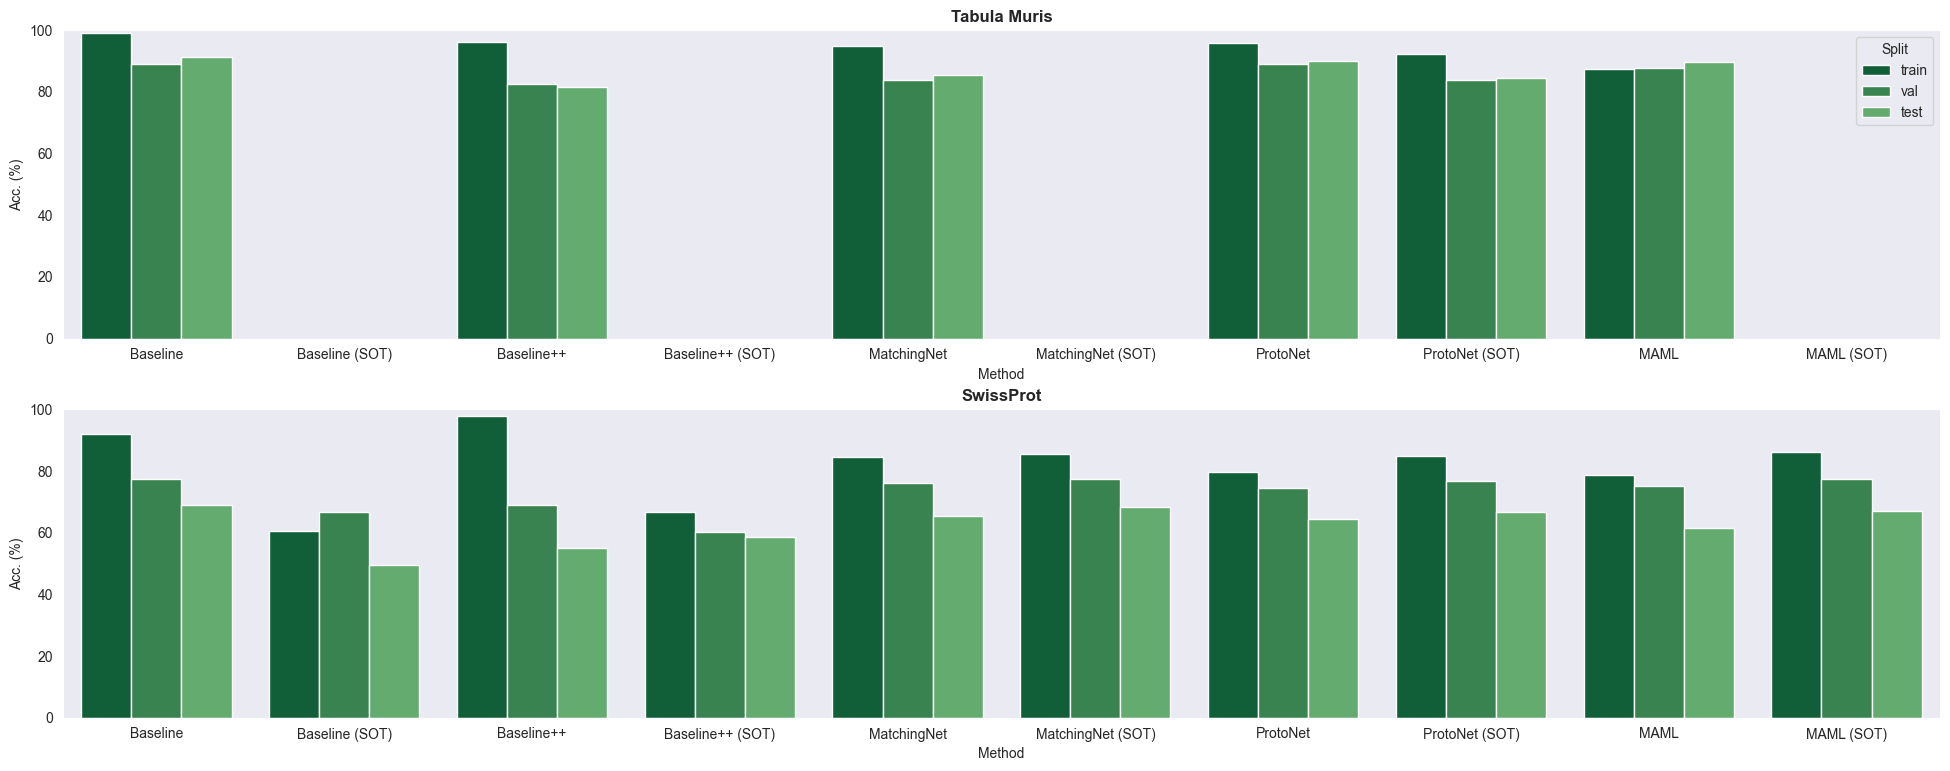

In [8]:
# Performance by split for all methods
fig, axs = plt.subplots(nrows=2, figsize=(20, 8))
fig.tight_layout(pad=3.0)


def pivot_acc(df):
    tmp = []
    for i, best_model in df.iterrows():
        for split in ["train", "val", "test"]:
            method_name = get_name(
                best_model[("config", "method")
                ], best_model[("config", "use_sot")]
            )
            tmp.append(
                {
                    "method": method_name,
                    "split": split,
                    "acc": best_model[("eval", f"{split}/acc")],
                }
            )
    return pd.DataFrame(tmp)


sns.barplot(
    pivot_acc(df_best_runs_tm),
    x="method",
    y="acc",
    hue="split",
    order=STYLED_METHODS_WITH_SOT,
    ax=axs[0],
)
sns.barplot(
    pivot_acc(df_best_runs_sp),
    x="method",
    y="acc",
    hue="split",
    order=STYLED_METHODS_WITH_SOT,
    ax=axs[1],
)
# Set title
axs[0].set_title("Tabula Muris", fontweight="bold")
axs[1].set_title("SwissProt", fontweight="bold")

# Disable legend on first subplot
axs[0].get_legend().set_title("Split")
axs[1].get_legend().remove()

# Set y-axis limits
axs[0].set_ylim(0, 100)
axs[1].set_ylim(0, 100)

for ax in axs:
    ax.set_xlabel("Method")
    ax.set_ylabel("Acc. (%)")

fig.savefig(os.path.join(FIGURE_DIR, "benchmark-split-perf.pdf"),
            bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

### Performance by method with and without SOT

Here, we compare the performance of the different methods with and without SOT.
The left subplot shows the test performance on the Tabula Muris dataset, while
the right subplot shows the test performance on the Swissprot dataset.


ValueError: Length of values (10) does not match length of index (6)

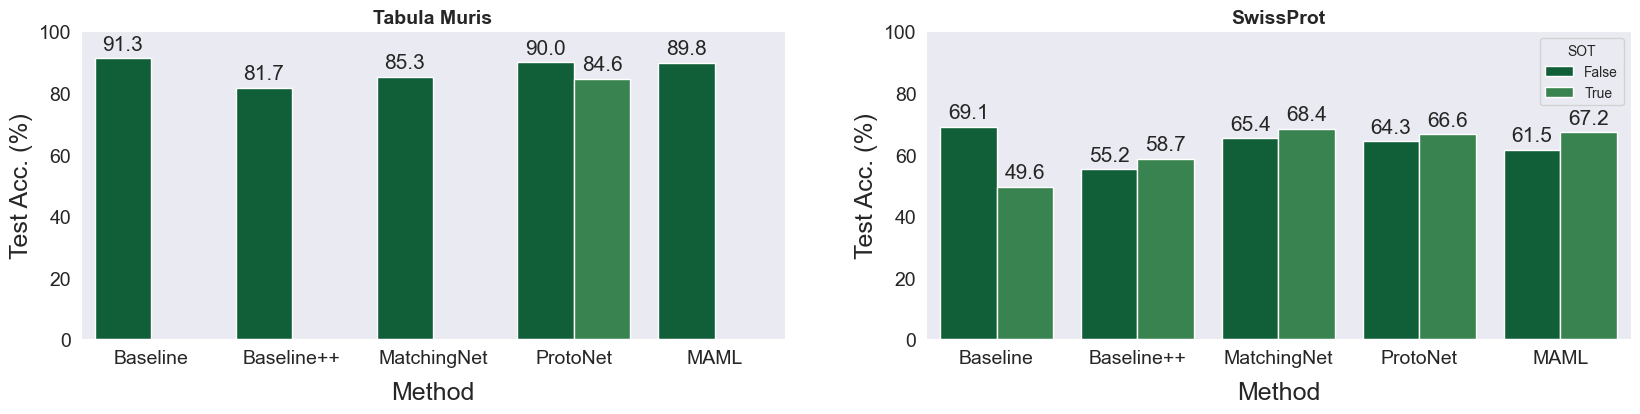

In [9]:
# Performance by method with and without SOT
fig, axs = plt.subplots(ncols=2, figsize=(20, 4))

sns.barplot(
    df_best_runs_tm,
    x=("config", "method"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    order=METHODS,
    ax=axs[0],
)

sns.barplot(
    df_best_runs_sp,
    x=("config", "method"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    ci="sd",
    order=METHODS,
    ax=axs[1],
)

# Set title
axs[0].set_title("Tabula Muris", fontweight="bold", fontsize=14)
axs[1].set_title("SwissProt", fontweight="bold", fontsize=14)

# Disable legend on first subplot
axs[0].get_legend().set_title("SOT")
axs[1].get_legend().set_title("SOT")

# Set axis labels
axs[0].set_xticklabels([get_name(name.get_text()) for name in axs[0].get_xticklabels()])
axs[1].set_xticklabels([get_name(name.get_text()) for name in axs[1].get_xticklabels()])

for ax in axs:
    ax.set_ylabel("Test Acc. (%)", fontsize=18)
    ax.set_xlabel("Method", fontsize=18)

# Remove legend in left plot
axs[0].get_legend().remove()

# Increasing tick size
axs[0].tick_params(labelsize=14)
axs[1].tick_params(labelsize=14)

axs[0].set_ylim(0, 100)
axs[1].set_ylim(0, 100)

# Adding padding between ticks and labels
axs[0].xaxis.labelpad = 10
axs[1].xaxis.labelpad = 10

# Add percentage to each bar
for p in axs[0].patches:
    axs[0].annotate(
        f"{p.get_height():.1f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
        fontsize=15,
    )

# Add percentage to each bar
for p in axs[1].patches:
    axs[1].annotate(
        f"{p.get_height():.1f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
        fontsize=15,
    )

# Add percentage to each bar
errors = df_best_runs_sp[("eval", "test/acc_ci")]
df_best_runs_sp["method_order"] = pd.Categorical(
    df_best_runs_sp[("config", "method")], categories=METHODS, ordered=True
)
df_best_runs_tm["method_order"] = pd.Categorical(
    df_best_runs_sp[("config", "method")], categories=METHODS, ordered=True
)

# Sort by the custom order
sp_errors = df_best_runs_sp.sort_values(["method_order", ("config", "use_sot")])[
    ("eval", "test/acc_ci")
]
tm_errors = df_best_runs_tm.sort_values(["method_order", ("config", "use_sot")])[
    ("eval", "test/acc_ci")
]

for i, p in enumerate(axs[0].patches):
    axs[0].errorbar(
        p.get_x() + p.get_width() / 2.0,
        p.get_height(),
        yerr=sp_errors[i],
        fmt="none",
        color="black",
        capsize=5,
    )

for i, p in enumerate(axs[1].patches):
    axs[1].errorbar(
        p.get_x() + p.get_width() / 2.0,
        p.get_height(),
        yerr=tm_errors[i],
        fmt="none",
        color="black",
        capsize=5,
    )

# Save figure
fig.savefig(os.path.join(FIGURE_DIR, "benchmark-perf.pdf"), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

In [ ]:
df_best_runs_sp["method_order"] = pd.Categorical(
    df_best_runs_sp[("config", "method")], categories=METHODS, ordered=True
)

# Sort by the custom order
df_best_runs_sp.sort_values(["method_order", ("config", "use_sot")])

### Hyperparameter Ablation

For each method including the SOT module we are searching over the following
hyperparameters:

- `lr`: The learning rate of the optimizer (`0.001`, `0.01`, `0.1`)
- `hidden_dim`: The hidden dimension of the backbone (`64`, `512`, `1024`)
- `sot_reg`: Regularization strength for the SOT module (`0.01`, `0.1`, `1.0`)
- `sot_dist`: The distance function used for the SOT module (`euclidean`,
  `cosine`)

This leads to a total of $3 \times 3 \times 3 \times 2 = 54$ different tuning
runs for each model. Let's first verify that we have all runs necessary and then
analyse the effect of the hyperparameters on the performance.


In [ ]:
# Number of runs per experiment
experiment_config = [("config", c) for c in df_runs.config.columns]
df_runs.groupby(experiment_config).size().reset_index(name="count")

Here, we can visualise the effect of each hyperparameter individually for both
datasets separately. We are averaging the results of all tuning runs for each
hyperparameter value and method.


In [ ]:
num_hparams = len(df_runs.hparams.columns)

# Hyperparameter Effect on SwissProt for all methods
fig, axs = plt.subplots(ncols=num_hparams, figsize=(20, 4))
fig.suptitle("Effect of Hyperparameters on SwissProt", fontsize=16)
for ax, hparam in zip(axs, df_runs.hparams.columns):
    utils.visualise_hparams(df_runs, dataset="swissprot", hparam=hparam, ax=ax)

fig.savefig(os.path.join(FIGURE_DIR, "hparams-swissprot.pdf"), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

# Hyperparameter Effect on Tabula Muris for all methods
fig, axs = plt.subplots(ncols=num_hparams, figsize=(20, 4))
fig.suptitle("Effect of Hyperparameters on Tabula Muris", fontsize=16)
for ax, hparam in zip(axs, df_runs.hparams.columns):
    utils.visualise_hparams(df_runs, dataset="tabula_muris", hparam=hparam, ax=ax)

fig.savefig(os.path.join(FIGURE_DIR, "hparams-tabula-muris.pdf"), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

Next, we show the interaction of all hyper-parameters pairs and the method and
dataset performance.


✅ Saved figure to /Users/adam/school/epfl/deeplearning_biomedicine/few-shot-benchmark/report/figures.


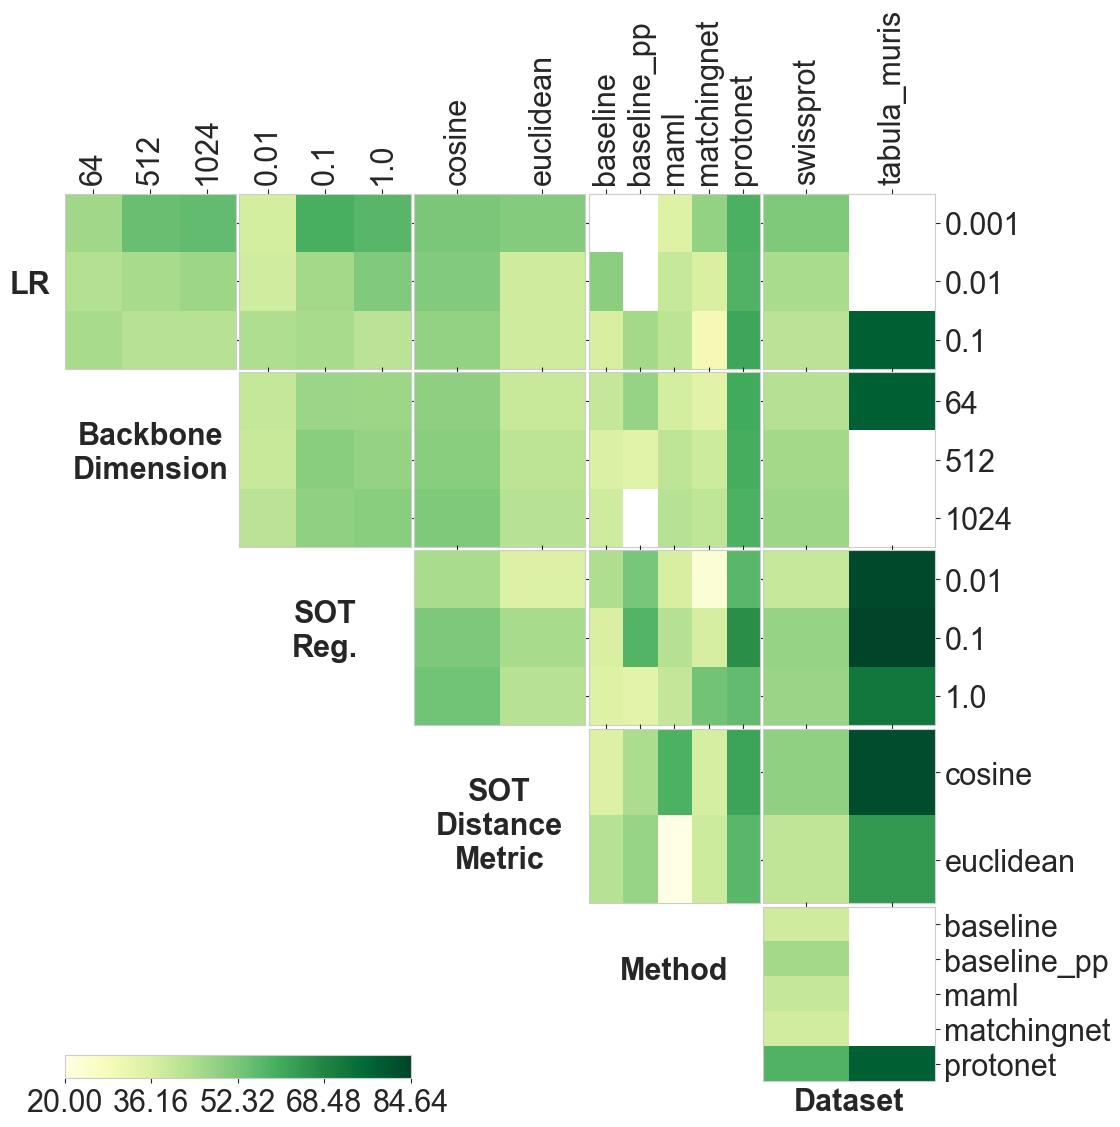

In [33]:
# Choose hyperparameters to visualise
param_cols = df_runs[("hparams")].columns.tolist()
param_tuples = [("hparams", param) for param in param_cols]
param_tuples.append(("config", "method"))
param_tuples.append(("config", "dataset"))
param_tuples
subset = df_runs[df_runs[("config", "use_sot")]]
fig = utils.grid(
    subset, param_tuples, metric="mean", cmap="YlGn", figsize=(10, 10)
)  # vmin, vmax automatically set

fig.savefig(os.path.join(FIGURE_DIR, "hparams-interaction.pdf"), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

### Generate LaTeX table


In [ ]:
# Parse the results for both the report
tm_res = utils.exp2results(df_best_runs_tm)
sp_res = utils.exp2results(df_best_runs_sp)

# Create a MultiIndex for the results where the first level is the dataset
tm_res = tm_res.set_index("Method")
tm_res.index = pd.MultiIndex.from_product([["TM"], tm_res.index])
sp_res = sp_res.set_index("Method")
sp_res.index = pd.MultiIndex.from_product([["SP"], sp_res.index])

# Concatenate the results
df_results = pd.concat([tm_res, sp_res])

# Get the latex
latex = utils.exp2latex(df_results)

# Save the latex
with open(os.path.join(TABLE_DIR, "tuned-benchmark.tex"), "w") as f:
    f.write(latex)

df_results

## Experiment 2: Way-Shot Analysis

---

Varying the number of shots per class.


In [ ]:
# Load experiment data for `way-shot` experiment
GROUP = "new-way-shot"

# Filter runs by group
group_runs = [run for run in runs if run.group == GROUP and run.state == "finished"]
print(f"✅ Found {len(group_runs)} runs")

In [ ]:
# Load runs into dataframe
df_runs = utils.load_to_df(group_runs)
print(f"✅ Loaded {len(df_runs)} runs.")

df_runs.head()

Only keep the best run for each experiment configuration. This only has an
effect if hyperparameter tuning was performed.


In [ ]:
# Group tuning runs by experiment configuration
df_best_runs = utils.get_best_run(df_runs, metric=("eval", "val/acc"))
print(f"✅ Filtered to {len(df_best_runs)} best runs.")

df_best_runs.head()

### Shot-Way-Analysis

Display the test/acc as a function of the number of shots per class and the
number of classes to distinguish between the different methods for ProtoNet
without and with SOT.


In [ ]:
# Set context to paper
sns.set_context("paper")
sns.set_style("dark")

# Plot test/acc vs. n_shot for SOT and non-SOT methods
fig, axs = plt.subplots(ncols=2, figsize=(7, 3.5), sharey=True)

# test/acc ~ n_shot
sns.scatterplot(
    data=df_best_runs,
    x=("config", "n_way"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    alpha=0.25,
    legend=True,
    ax=axs[0],
)
sns.lineplot(
    data=df_best_runs,
    x=("config", "n_way"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    legend=False,
    ax=axs[0],
)

# test/acc ~ n_way
sns.scatterplot(
    data=df_best_runs,
    x=("config", "n_shot"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    alpha=0.25,
    legend=False,
    ax=axs[1],
)
sns.lineplot(
    data=df_best_runs,
    x=("config", "n_shot"),
    y=("eval", "test/acc"),
    hue=("config", "use_sot"),
    legend=False,
    ax=axs[1],
)

# Set label size
labsize = 14

# Set title of the legend, adjust font size
axs[0].get_legend().set_title("SOT", prop={"size": 1})
for t in axs[0].get_legend().texts:
    t.set_fontsize(12)

# Set axis labels
axs[0].set_xlabel("N-Way", size=labsize)
axs[1].set_xlabel("N-Shot", size=labsize)

# Add padding between label of x-axis and tick labels
axs[0].xaxis.labelpad = 10
axs[1].xaxis.labelpad = 10

# Set axis labels
axs[0].set_ylabel("Test. Acc. (%)", size=labsize)
axs[1].set_ylabel("")

# Make the ticks descroptors bigger
axs[0].tick_params(labelsize=12)
axs[1].tick_params(labelsize=12)

# Set the tight layout
fig.tight_layout(pad=1.0)

# Save figure
fig.savefig(os.path.join(FIGURE_DIR, "way-shot.pdf"), bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

## Experiment 3: Understanding model performance

---

The goal of this section will be to understand the behaviour of the SOT module.
We will try to understand the improvements by looking at:

- **Embeddings during forward-pass**. Visualise the embeddings of support and
  query samples during episodes with and without SOT enabled.
- **Visualise the self-optimal transport plan.** Visualise the self-optimal
  transport plan for a few episodes via a heat map.
- **Understand model prediction patterns and errors.** Visualise the model
  predictions and errors for a few episodes with and without SOT enabled.

To get started, we will load two pre-trained models from the benchmarking
experiment. We will use two instances of `protonet` that were both trained on
the `tabula_muris` dataset. The first model was trained with the default
configuration, while the second model was trained with the same configuration
but with the `use_sot` flag set to `True`.


In [ ]:
# Experiments
GROUP = "model-behaviour"

# Filter runs by group
runs = list(
    reversed([run for run in runs if run.group == GROUP and run.state == "finished"])
)
print(f"✅ Loaded {len(runs)} runs")

# Load runs into dataframe
df_runs = utils.load_to_df(runs)
df_runs = df_runs.iloc[::-1]

df_runs.head()

In [ ]:
# Initialise data loaders and model
models = []
for run in runs:
    # Load data loaders and model
    train_loader, val_loader, test_loader, model = utils.init_all(run)
    models.append(model)

print(f"✅ Initialised data loader and model.")

In [ ]:
# Download artifact (model weights)
for run in runs:
    if not os.path.exists(os.path.join(ARTIFACT_DIR, run.id)):
        utils.download_artifact(
            api,
            wandb_entity=WANDB_ENTITY,
            wandb_project=WANDB_PROJECT,
            artifact_dir=ARTIFACT_DIR,
            run_id=run.id,
        )
    print(f"✅ Downloaded artifact for run {run.id}.")

In [ ]:
# Load model weights
weight_path = os.path.join(ARTIFACT_DIR, runs[0].id, "best_model.pt")
models[0].load_state_dict(torch.load(weight_path))

weight_path = os.path.join(ARTIFACT_DIR, runs[1].id, "best_model.pt")
models[1].load_state_dict(torch.load(weight_path))

weight_path = os.path.join(ARTIFACT_DIR, runs[2].id, "best_model.pt")
models[2].load_state_dict(torch.load(weight_path))

weight_path = os.path.join(ARTIFACT_DIR, runs[3].id, "best_model.pt")
models[3].load_state_dict(torch.load(weight_path))

print(f"✅ Loaded all model weights.")

In [ ]:
# Evaluate performance
print("\nEvaluating ProtoNet w/o SOT...")
models[0].test_loop(train_loader)
models[0].test_loop(val_loader)
models[0].test_loop(test_loader)

print("Evaluating ProtoNet w SOT...")
models[1].test_loop(train_loader)
models[1].test_loop(val_loader)
models[1].test_loop(test_loader)

print("\nEvaluating Baseline w/ SOT...")
models[2].test_loop(train_loader)
models[2].test_loop(val_loader)
models[2].test_loop(test_loader)

print("\nEvaluating ProtoNet w/ SOT w/o SE...")
models[3].test_loop(train_loader)
models[3].test_loop(val_loader)
models[3].test_loop(test_loader)

print(f"✅ Evaluated both models.")

We have correctly loaded the model weights by confirming the performance on the
`train`, `val` and `test` split for ProtoNet on SwissProt with and without SOT.


### Visualise Embeddings


In [ ]:
# Visualise episode for Protnet w/ SOT
for loader in [train_loader, val_loader, test_loader]:
    utils.visualise_episode(train_loader, models[1])

In [ ]:
# Visualise episode for Protnet w/o SOT
for loader in [train_loader, val_loader, test_loader]:
    utils.visualise_episode(train_loader, models[2])

### Visualise SOT transport plan

Here we visualise the self-optimal transport plan for a few episodes.


In [ ]:
# Visualise transport plan for Protonet w/ SOT on splits
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
for ax, loader in zip(axs, [train_loader, val_loader, test_loader]):
    x, _ = next(iter(loader))
    utils.visualise_transport_plan(x, models[1], ax=ax)

In [ ]:
# Visualise transport plan for ProtoNet w/ SOT w/o SE on splits
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
for ax, loader in zip(axs, [train_loader, val_loader, test_loader]):
    x, _ = next(iter(loader))
    utils.visualise_transport_plan(x, models[3], ax=ax)

In [ ]:
# Visualise transport plan for Baseline w/ SOT on splits
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
for ax, loader in zip(axs, [train_loader, val_loader, test_loader]):
    x, _ = next(iter(loader))
    utils.visualise_transport_plan(x, models[2], ax=ax)

In [ ]:
# Compare transport plan of ProtoNet w/ and w/o SE and w/ SOT
fig, axs = plt.subplots(ncols=3, figsize=(16, 5))
fig.tight_layout(pad=3.0)

x, _ = next(iter(test_loader))

utils.visualise_transport_plan(x, models[1], ax=axs[0])
utils.visualise_lstm(x, models[1], ax=axs[1])
utils.visualise_transport_plan(x, models[3], ax=axs[2])

print()

In [ ]:
# Compare transport plan of ProtoNet with Baseline on test split
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
fig.tight_layout(pad=3.0)

x, _ = next(iter(test_loader))
utils.visualise_transport_plan(x, models[1], ax=axs[0])
utils.visualise_transport_plan(x, models[2], ax=axs[1])

# Remove heatbar from axs[0]
bar = axs[0].collections[0].colorbar
axs[0].collections[0].colorbar.remove()
axs[1].collections[0].colorbar.remove()
pn_acc = axs[0].title.get_text().split(" ")[-1]
b_acc = axs[1].title.get_text().split(" ")[-1]
axs[0].set_title(f"ProtoNet SOT Embeddings (Acc. = {pn_acc}", fontsize=14)
axs[1].set_title(f"Baseline SOT Embeddings (Acc. = {b_acc}", fontsize=14)

# Add colbar in between the two plots
# axs[0].figure.colorbar(bar, ax=axs, location="right")p
cbar_ax = fig.add_axes([0.485, 0.25, 0.02, 0.5])
fig.colorbar(axs[0].collections[0], cax=cbar_ax, orientation="vertical")

# Save figure
fig.savefig(os.path.join(FIGURE_DIR, "sot-embeddings.pdf"),
            bbox_inches="tight")
print(f"✅ Saved figure to {FIGURE_DIR}.")

### Visualise confusion patterns

p fig.subplots_adjust(bottom=0.2)


In [ ]:
# Confusion matrix for Protonet w/ SOT on all splits
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
for ax, loader in zip(axs, [train_loader, val_loader, test_loader]):
    utils.visualise_confusion_matrix(loader, models[0], ax=ax)

In [ ]:
# Confusion matrix for Protonet w/o SOT on all splits
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))
for ax, loader in zip(axs, [train_loader, val_loader, test_loader]):
    utils.visualise_confusion_matrix(loader, models[1], ax=ax)